In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import random as rdm
import os
np.random.seed(0)
import seaborn as sns
from scipy.optimize import linprog

In [2]:
#problem(1)
Rfunc1 = np.zeros((10,10))
Rfunc1[-1][-1] = 1.0
Rfunc2 = np.zeros((10, 10))
Rfunc2[1:7,4] = -100.0
Rfunc2[1,5] = -100.0
Rfunc2[1:4,6] = Rfunc2[7:9,6] = -100.0
Rfunc2[3,7] = Rfunc2[7,7] = -100.0
Rfunc2[3:8,8] = -100.0
Rfunc2[-1][-1] = 10.0

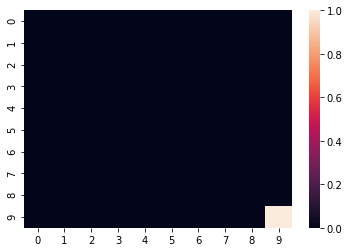

In [3]:
hm1 = sns.heatmap(Rfunc1)

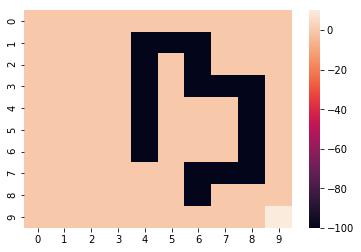

In [4]:
hm2 = sns.heatmap(Rfunc2)

In [5]:
#problem2
width = 10
height = 10
tp = np.zeros((height * width, 5, 4)) # third dimension is direction, last denotes action
#direction to next state 0 : up 1 : right 2 : down 3 : left 4: stay
#action 0 : up 1 : right 2 : down 3 : left
w = 0.1
dx = [0, 1, 0, -1, 0]
dy = [-1, 0, 1, 0, 0]

In [6]:
def isCorner(x, y, height, width):
    return (((y == height - 1) or (y == 0)) and ((x == width - 1) or (x == 0)))
def isEdge(x, y, height, width):
    return (x == 0) or (x == height - 1) or (y == 0) or(y == width - 1)
def offGrid(x, y, height, width):
    return (x < 0) or (x >= height) or (y < 0) or(y >= width)

In [7]:
def cornerSol(x, y, tp, height, width, w):
    state = x * height + y
    for i in range(4): #action
        if(offGrid(x + dx[i], y + dy[i], height, width)):
            for j in range(4):
                if not offGrid(x + dx[j], y + dy[j], height, width):
                    tp[state][j][i] = w / 4.0
            tp[state][4][i] = 1 - w / 2.0
        else:
            for j in range(4):
                if i == j:
                    tp[state][j][i] = 1 - w + w / 4.0
                elif not offGrid(x + dx[j], y + dy[j], height, width):
                    tp[state][j][i] = w / 4.0
            tp[state][4][i] = w / 2.0
            
def edgeSol(x, y, tp, height, width, w):
    state = x * height + y
    for i in range(4): #action
        if(offGrid(x + dx[i], y + dy[i], height, width)):
            for j in range(4):
                if not offGrid(x + dx[j], y + dy[j], height, width):
                    tp[state][j][i] = w / 4.0
            tp[state][4][i] = 1 - w + w / 4.0
        else:
            for j in range(4):
                if i == j:
                    tp[state][j][i] = 1 - w + w / 4.0
                elif not offGrid(x + dx[j], y + dy[j], height, width):
                    tp[state][j][i] = w / 4.0
            tp[state][4][i] = w / 4.0   
            
def innerSol(x, y, tp, height, width, w):
    state = x * height + y
    for i in range(4): # atcion
        for j in range(4):
            if i == j:
                tp[state][j][i] = 1 - w + w / 4.0
            else:
                tp[state][j][i] = w / 4.0

In [8]:
w = 0.1
for i in range(height * width): #calculate transition prob
    x = i // height
    y = i % height
    if isCorner(x, y, height, width):
        cornerSol(x, y, tp, height, width, w)
    elif isEdge(x, y, height, width):
        edgeSol(x, y, tp, height, width, w)
    else:
        innerSol(x, y, tp, height, width, w)

In [9]:
def calStateValue(state, tp, Rfunc, Vs, discount):
    value = np.zeros(4)
    x = state // height
    y = state % height
    for action in range(4):
        for i in range(5):
            x1 = x + dx[i]
            y1 = y + dy[i]
            if offGrid(x1, y1, height, width):
                continue
            state1 = x1 * height + y1
            value[action] += tp[state][i][action] * (Rfunc[y1][x1] + discount * Vs[state1])
    return value
def calVs(Vs, tp, Rfunc, discount, theta):
    while True:
        delta = 0.0
        for s in range(width * height):
            actionValue = calStateValue(s, tp, Rfunc, Vs, discount)
            maxActionValue = max(actionValue)
            delta = max(np.abs(maxActionValue - Vs[s]), delta)
            Vs[s] = maxActionValue
        if delta < theta:
            break

In [10]:
Vs1 = np.zeros(height * width)
discount = 0.8
theta = 0.01
calVs(Vs1, tp, Rfunc1, discount, theta)#calculate state value for each state

In [11]:
from tabulate import tabulate

In [12]:
Vs1_2d = Vs1.reshape((height, width))
print(tabulate(Vs1_2d.T,  tablefmt='fancy_grid'))

╒═══════════╤═══════════╤══════════╤══════════╤══════════╤══════════╤══════════╤══════════╤══════════╤══════════╕
│ 0.0417957 │ 0.0628379 │ 0.089742 │ 0.123849 │ 0.167081 │ 0.221883 │ 0.291354 │ 0.37942  │ 0.490983 │ 0.609648 │
├───────────┼───────────┼──────────┼──────────┼──────────┼──────────┼──────────┼──────────┼──────────┼──────────┤
│ 0.0628379 │ 0.0878701 │ 0.121557 │ 0.164514 │ 0.219246 │ 0.28899  │ 0.377871 │ 0.491061 │ 0.633219 │ 0.787354 │
├───────────┼───────────┼──────────┼──────────┼──────────┼──────────┼──────────┼──────────┼──────────┼──────────┤
│ 0.089742  │ 0.121557  │ 0.16439  │ 0.219132 │ 0.288903 │ 0.377826 │ 0.491156 │ 0.63549  │ 0.817355 │ 1.0186   │
├───────────┼───────────┼──────────┼──────────┼──────────┼──────────┼──────────┼──────────┼──────────┼──────────┤
│ 0.123849  │ 0.164514  │ 0.219132 │ 0.2889   │ 0.377825 │ 0.491159 │ 0.635601 │ 0.81961  │ 1.05219  │ 1.31506  │
├───────────┼───────────┼──────────┼──────────┼──────────┼──────────┼──────────┼────────

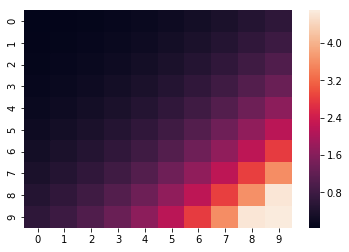

In [13]:
#problem3
hm3 = sns.heatmap(Vs1_2d.T)

In [14]:
#problem5
arrows = ['↑','→','↓','←']
def calOptimalAction(optimalAction, tp, Rfunc, Vs, discount):
    for s in range(height * width):
        actionValue = calStateValue(s, tp, Rfunc, Vs, discount)
        optimal = np.argmax(actionValue)
        optimalAction[s] = optimal
def action2Arrow(action, arrows):
    return [arrows[int(i)] for i in action]

In [15]:
optimalAction1 = np.zeros(height * width)
calOptimalAction(optimalAction1, tp, Rfunc1, Vs1, discount)

In [16]:
optimalAction1_2d = optimalAction1.reshape((height, width))
arrows1 = action2Arrow(optimalAction1, arrows)
path1 = np.array(arrows1).reshape((height,width)).T
print(tabulate(optimalAction1_2d.T,  tablefmt='fancy_grid'))

╒═══╤═══╤═══╤═══╤═══╤═══╤═══╤═══╤═══╤═══╕
│ 2 │ 1 │ 1 │ 1 │ 1 │ 1 │ 1 │ 2 │ 2 │ 2 │
├───┼───┼───┼───┼───┼───┼───┼───┼───┼───┤
│ 2 │ 1 │ 1 │ 1 │ 1 │ 1 │ 2 │ 2 │ 2 │ 2 │
├───┼───┼───┼───┼───┼───┼───┼───┼───┼───┤
│ 2 │ 2 │ 1 │ 1 │ 1 │ 2 │ 2 │ 2 │ 2 │ 2 │
├───┼───┼───┼───┼───┼───┼───┼───┼───┼───┤
│ 2 │ 2 │ 2 │ 2 │ 2 │ 2 │ 2 │ 2 │ 2 │ 2 │
├───┼───┼───┼───┼───┼───┼───┼───┼───┼───┤
│ 2 │ 2 │ 2 │ 1 │ 2 │ 2 │ 2 │ 2 │ 2 │ 2 │
├───┼───┼───┼───┼───┼───┼───┼───┼───┼───┤
│ 2 │ 2 │ 1 │ 1 │ 1 │ 1 │ 2 │ 2 │ 2 │ 2 │
├───┼───┼───┼───┼───┼───┼───┼───┼───┼───┤
│ 2 │ 1 │ 1 │ 1 │ 1 │ 1 │ 1 │ 2 │ 2 │ 2 │
├───┼───┼───┼───┼───┼───┼───┼───┼───┼───┤
│ 1 │ 1 │ 1 │ 1 │ 1 │ 1 │ 1 │ 1 │ 2 │ 2 │
├───┼───┼───┼───┼───┼───┼───┼───┼───┼───┤
│ 1 │ 1 │ 1 │ 1 │ 1 │ 1 │ 1 │ 1 │ 1 │ 2 │
├───┼───┼───┼───┼───┼───┼───┼───┼───┼───┤
│ 1 │ 1 │ 1 │ 1 │ 1 │ 1 │ 1 │ 1 │ 1 │ 1 │
╘═══╧═══╧═══╧═══╧═══╧═══╧═══╧═══╧═══╧═══╛


In [17]:
print(tabulate(path1))

-  -  -  -  -  -  -  -  -  -
↓  →  →  →  →  →  →  ↓  ↓  ↓
↓  →  →  →  →  →  ↓  ↓  ↓  ↓
↓  ↓  →  →  →  ↓  ↓  ↓  ↓  ↓
↓  ↓  ↓  ↓  ↓  ↓  ↓  ↓  ↓  ↓
↓  ↓  ↓  →  ↓  ↓  ↓  ↓  ↓  ↓
↓  ↓  →  →  →  →  ↓  ↓  ↓  ↓
↓  →  →  →  →  →  →  ↓  ↓  ↓
→  →  →  →  →  →  →  →  ↓  ↓
→  →  →  →  →  →  →  →  →  ↓
→  →  →  →  →  →  →  →  →  →
-  -  -  -  -  -  -  -  -  -


# IRL #

In [18]:
def tp2tpm(height, width, tp):
    tpm = np.zeros((height * width, 4, height * width))
    for s in range(tp.shape[0]):
        x = s // height
        y = s % height
        for action in range(tp.shape[2]):
            for i in range(tp.shape[1]):
                x1 = x + dx[i]
                y1 = y + dy[i]
                if not offGrid(x1, y1, height, width):
                    s1 = x1 * height + y1
                    tpm[s][action][s1] = tp[s][i][action]
    return tpm

In [19]:
def calculate_LP_D(a, s, policy, gamma, tp):
    # (Pa1 −Pa)(I−γPa1)−1
    return np.dot(tp[int(policy[s]), s] - tp[a, s], np.linalg.inv(np.eye(100) - gamma*tp[int(policy[s])]))

In [42]:
def calculate_accuracy(n_states, ground_truth, extracted_reward):
    extracted_reward = extracted_reward.reshape((height,width))
    Vs1 = np.zeros(height * width)
    discount = 0.8
    theta = 0.01
    calVs(Vs1, tp, extracted_reward, discount, theta)
    optimalAction = np.zeros(height * width)
    calOptimalAction(optimalAction, tp, extracted_reward, Vs1, discount)
    count = 0
    for i in range(n_states):
        if ground_truth[i] == optimalAction[i]:
            count += 1
    return float(count)/float(n_states)

In [43]:
#Question 11:
import numpy as np
from cvxopt import solvers,matrix
lamda_list = np.linspace(0,5,100)
# lamda_list = np.linspace(1,5,100)
A = {0,1,2,3}
n_actions = 4
n_states = 100
gamma = 0.8
tpm = tp2tpm(height, width, tp)
# print(tpm.shape)
transition_probability = np.transpose(tpm, (1, 0, 2))
# print(transition_probability)
Rmax = Rfunc1.max()
def perform_IRL(optimalAction, transition_probability, Rmax):
    for lamda in lamda_list:
        n_states = 100
        policy = optimalAction
        C = -np.hstack([np.zeros(100), np.ones(100), -lamda*np.ones(100), np.zeros(100)]) 
#         print(C.shape)   
#         print(A - {policy[1]})
        T_stack = np.vstack([
                calculate_LP_D(a, s, policy, gamma, transition_probability)
                for s in range(n_states)
                for a in A - {policy[s]}
            ])
        one_stack = np.vstack([
                np.eye(1, n_states, s)
                for s in range(n_states)
                for a in A - {policy[s]}
            ])
        # X = [R, T, U, M]
        # (Pa1 −Pa)(I−γPa1)−1 * R >= T => -(Pa1 −Pa)(I−γPa1)−1 * R <= -T => -(Pa1 −Pa)(I−γPa1)−1 * R + T <= 0
        D_0 = np.hstack([-T_stack, one_stack,np.zeros((300,100)),np.zeros((300,100))])
        # (Pa1 −Pa)(I−γPa1)−1 * R >= 0 => -(Pa1 −Pa)(I−γPa1)−1 * R <= 0
        D_1 = np.hstack([-T_stack, np.zeros((300,100)),np.zeros((300,100)),np.zeros((300,100))])
        # R <= u and R >= -u => R-u<=0 and -R-u <=0
        D_2 = np.hstack([np.eye(n_states),np.zeros((100,100)),-np.eye(n_states),np.zeros((100,100))])
        D_3 = np.hstack([-np.eye(n_states),np.zeros((100,100)),-np.eye(n_states),np.zeros((100,100))])
        # R <= Rmax and R >= -Rmax => R - Rmax <=0 and -R - Rmax <=0
        D_4 = np.hstack([np.eye(n_states), np.zeros((100,100)), np.zeros((100,100)), -np.eye(n_states)])
        D_5 = np.hstack([-np.eye(n_states), np.zeros((100,100)), np.zeros((100,100)), -np.eye(n_states)])

        D = np.vstack([D_0, D_1, D_2, D_3, D_4, D_5])
        d = matrix(D)
        B = np.zeros((1000,1))
        b = matrix(B)
        c = matrix(C)
        results = solvers.lp(c, d, b)
        r = np.asarray(results["x"][:n_states], dtype=np.double)
        # print(r)
        res = r.reshape((n_states,))
#         print(res)
        print(calculate_accuracy(100, optimalAction, res))
    

In [44]:
perform_IRL(optimalAction1, transition_probability, Rmax)

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  1e+03  3e+01  2e+01  1e+00
 1: -2.5706e+00 -0.0000e+00  7e+02  1e+01  7e+00  3e+00
 2: -7.5495e+00 -0.0000e+00  2e+03  1e+01  6e+00  8e+00
 3: -6.6356e+01 -0.0000e+00  2e+04  1e+01  7e+00  7e+01
 4: -1.2930e+03 -0.0000e+00  5e+05  1e+01  7e+00  1e+03
 5: -1.2779e+05 -0.0000e+00  5e+07  1e+01  7e+00  1e+05
 6: -1.2779e+07 -0.0000e+00  5e+09  1e+01  7e+00  1e+07
 7: -1.2779e+09 -0.0000e+00  5e+11  1e+01  7e+00  1e+09
Certificate of dual infeasibility found.
0.68
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  1e+03  3e+01  2e+01  1e+00
 1: -2.7316e+00 -0.0000e+00  6e+02  1e+01  7e+00  3e+00
 2: -5.9919e+00 -0.0000e+00  1e+03  1e+01  5e+00  6e+00
 3: -4.5681e+01 -0.0000e+00  1e+04  1e+01  5e+00  5e+01
 4: -8.6905e+02 -0.0000e+00  2e+05  1e+01  6e+00  9e+02
 5: -8.4893e+04 -0.0000e+00  2e+07  1e+01  6e+00  8e+04
 6: -8.4894e+06 -0.0000e+00  2e+09  1e+01  6e+00  8e+06
 7: -8

 9: -2.2490e+08 -0.0000e+00  2e+10  9e-01  4e-01  2e+08
Certificate of dual infeasibility found.
0.68
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  1e+01  1e+00
 1: -2.5818e+00 -0.0000e+00  3e+02  1e+01  4e+00  3e+00
 2: -1.6015e+00 -0.0000e+00  8e+01  4e+00  2e+00  2e+00
 3: -4.8667e-01 -0.0000e+00  3e+01  1e+00  6e-01  5e-01
 4: -2.3308e-01 -0.0000e+00  1e+01  5e-01  2e-01  2e-01
 5: -4.7134e-01 -0.0000e+00  3e+01  5e-01  2e-01  5e-01
 6: -3.1471e+00 -0.0000e+00  2e+02  4e-01  2e-01  3e+00
 7: -2.5720e+02 -0.0000e+00  2e+04  4e-01  2e-01  3e+02
 8: -2.5714e+04 -0.0000e+00  2e+06  4e-01  2e-01  3e+04
 9: -2.5714e+06 -0.0000e+00  2e+08  4e-01  2e-01  3e+06
10: -2.5714e+08 -0.0000e+00  2e+10  4e-01  2e-01  3e+08
Certificate of dual infeasibility found.
0.66
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  1e+01  1e+00
 1: -2.4646e+00 -0.0000e+00  3e+02  1e+01  4e+00  3e+00
 2: -1.4661e+00 

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  9e+00  1e+00
 1: -1.4117e+00 -0.0000e+00  3e+02  9e+00  3e+00  2e+00
 2: -7.0336e-01 -0.0000e+00  6e+01  3e+00  9e-01  8e-01
 3: -1.8244e-01 -0.0000e+00  1e+01  9e-01  3e-01  2e-01
 4: -1.3932e-02 -0.0000e+00  1e+00  1e-01  3e-02  2e-02
 5: -1.1903e-04 -0.0000e+00  2e-02  2e-03  5e-04  2e-04
 6: -1.1898e-06 -0.0000e+00  2e-04  2e-05  5e-06  2e-06
 7: -1.1898e-08 -0.0000e+00  2e-06  2e-07  5e-08  2e-08
 8: -1.1898e-10 -0.0000e+00  2e-08  2e-09  5e-10  2e-10
Optimal solution found.
0.66
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  9e+00  1e+00
 1: -1.3508e+00 -0.0000e+00  3e+02  9e+00  3e+00  2e+00
 2: -6.5830e-01 -0.0000e+00  5e+01  3e+00  8e-01  8e-01
 3: -1.6792e-01 -0.0000e+00  1e+01  8e-01  2e-01  2e-01
 4: -8.3763e-03 -0.0000e+00  1e+00  8e-02  2e-02  1e-02
 5: -7.7902e-05 -0.0000e+00  1e-02  9e-04  3e-04  1e-04
 6: -7.7882e-07 -0.0000

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  7e+00  1e+00
 1: -7.9168e-01 -0.0000e+00  3e+02  9e+00  2e+00  1e+00
 2: -2.5955e-01 -0.0000e+00  3e+01  2e+00  3e-01  3e-01
 3: -1.2999e-02 -0.0000e+00  2e+00  1e-01  3e-02  2e-02
 4: -1.3502e-04 -0.0000e+00  2e-02  2e-03  3e-04  2e-04
 5: -1.3499e-06 -0.0000e+00  2e-04  2e-05  3e-06  2e-06
 6: -1.3499e-08 -0.0000e+00  2e-06  2e-07  3e-08  2e-08
 7: -1.3499e-10 -0.0000e+00  2e-08  2e-09  3e-10  2e-10
Optimal solution found.
0.62
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  7e+00  1e+00
 1: -7.6568e-01 -0.0000e+00  3e+02  8e+00  2e+00  1e+00
 2: -2.4723e-01 -0.0000e+00  3e+01  2e+00  3e-01  3e-01
 3: -1.0203e-02 -0.0000e+00  2e+00  1e-01  3e-02  1e-02
 4: -1.0567e-04 -0.0000e+00  2e-02  1e-03  3e-04  1e-04
 5: -1.0565e-06 -0.0000e+00  2e-04  1e-05  3e-06  1e-06
 6: -1.0565e-08 -0.0000e+00  2e-06  1e-07  3e-08  1e-08
 7: -1.0565e-10 -0.0000

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  5e+00  1e+00
 1: -4.9022e-01 -0.0000e+00  2e+02  7e+00  1e+00  7e-01
 2: -1.3101e-01 -0.0000e+00  3e+01  1e+00  2e-01  2e-01
 3: -2.5709e-03 -0.0000e+00  1e+00  7e-02  1e-02  5e-03
 4: -2.6097e-05 -0.0000e+00  1e-02  7e-04  1e-04  5e-05
 5: -2.6095e-07 -0.0000e+00  1e-04  7e-06  1e-06  5e-07
 6: -2.6095e-09 -0.0000e+00  1e-06  7e-08  1e-08  5e-09
 7: -2.6095e-11 -0.0000e+00  1e-08  7e-10  1e-10  5e-11
Optimal solution found.
0.66
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  5e+00  1e+00
 1: -4.7729e-01 -0.0000e+00  2e+02  7e+00  1e+00  7e-01
 2: -1.2684e-01 -0.0000e+00  3e+01  1e+00  2e-01  2e-01
 3: -2.5362e-03 -0.0000e+00  1e+00  6e-02  1e-02  5e-03
 4: -2.5688e-05 -0.0000e+00  1e-02  7e-04  1e-04  5e-05
 5: -2.5686e-07 -0.0000e+00  1e-04  7e-06  1e-06  5e-07
 6: -2.5686e-09 -0.0000e+00  1e-06  7e-08  1e-08  5e-09
 7: -2.5686e-11 -0.0000

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  4e+00  1e+00
 1: -3.4797e-01 -0.0000e+00  2e+02  6e+00  8e-01  6e-01
 2: -8.3902e-02 -0.0000e+00  2e+01  1e+00  1e-01  1e-01
 3: -1.5190e-03 -0.0000e+00  7e-01  3e-02  4e-03  2e-03
 4: -1.5176e-05 -0.0000e+00  7e-03  3e-04  4e-05  2e-05
 5: -1.5176e-07 -0.0000e+00  7e-05  3e-06  4e-07  2e-07
 6: -1.5176e-09 -0.0000e+00  7e-07  3e-08  4e-09  2e-09
 7: -1.5176e-11 -0.0000e+00  7e-09  3e-10  4e-11  2e-11
Optimal solution found.
0.63
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  4e+00  1e+00
 1: -3.4225e-01 -0.0000e+00  2e+02  6e+00  8e-01  5e-01
 2: -8.2367e-02 -0.0000e+00  2e+01  1e+00  1e-01  1e-01
 3: -1.4656e-03 -0.0000e+00  7e-01  3e-02  4e-03  2e-03
 4: -1.4643e-05 -0.0000e+00  7e-03  3e-04  4e-05  2e-05
 5: -1.4642e-07 -0.0000e+00  7e-05  3e-06  4e-07  2e-07
 6: -1.4642e-09 -0.0000e+00  7e-07  3e-08  4e-09  2e-09
 7: -1.4642e-11 -0.0000

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  3e+00  1e+00
 1: -2.7193e-01 -0.0000e+00  2e+02  6e+00  6e-01  5e-01
 2: -6.2936e-02 -0.0000e+00  2e+01  9e-01  9e-02  9e-02
 3: -8.9747e-04 -0.0000e+00  5e-01  2e-02  2e-03  1e-03
 4: -8.9655e-06 -0.0000e+00  5e-03  2e-04  2e-05  1e-05
 5: -8.9653e-08 -0.0000e+00  5e-05  2e-06  2e-07  1e-07
 6: -8.9653e-10 -0.0000e+00  5e-07  2e-08  2e-09  1e-09
 7: -8.9653e-12 -0.0000e+00  5e-09  2e-10  2e-11  1e-11
Optimal solution found.
0.61
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  3e+00  1e+00
 1: -2.6789e-01 -0.0000e+00  2e+02  6e+00  6e-01  5e-01
 2: -6.1641e-02 -0.0000e+00  2e+01  9e-01  9e-02  9e-02
 3: -8.6792e-04 -0.0000e+00  5e-01  2e-02  2e-03  1e-03
 4: -8.6703e-06 -0.0000e+00  5e-03  2e-04  2e-05  1e-05
 5: -8.6702e-08 -0.0000e+00  5e-05  2e-06  2e-07  1e-07
 6: -8.6702e-10 -0.0000e+00  5e-07  2e-08  2e-09  1e-09
 7: -8.6702e-12 -0.0000

In [ ]:
print(optimalAction1)

In [ ]:
#problem6
Vs2 = np.zeros(height * width)
calVs(Vs2, tp, Rfunc2, discount, theta)#calculate state value for each state

In [ ]:
Vs2_2d = Vs2.reshape((height, width))
print(tabulate(Vs2_2d.T,  tablefmt='fancy_grid'))

In [ ]:
#problem7
hm4 = sns.heatmap(Vs2_2d.T)

In [ ]:
#problem9
optimalAction2 = np.zeros(height * width)
calOptimalAction(optimalAction2, tp, Rfunc2, Vs2, discount)

In [ ]:
optimalAction2_2d = optimalAction2.reshape((height, width))
arrows2 = action2Arrow(optimalAction2, arrows)
path2 = np.array(arrows2).reshape((height,width)).T
print(tabulate(optimalAction2_2d.T,  tablefmt='fancy_grid'))

In [ ]:
print(tabulate(path2))

In [ ]:
# tpm = tp2tpm(height, width, tp)
# print(tpm.shape)
# transition_probability = np.transpose(tpm, (1, 0, 2))
# print(transition_probability)
Rmax = Rfunc2.max()
perform_IRL(optimalAction2, transition_probability, Rmax)


In [ ]:
np.ones(n_states, n_states).shape